In [59]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.data import SAT1_STAGES_ACCURACY, COMMON_STAGES, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix, plot_predictions_on_epoch
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader
from mne.io import read_info
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
DATA_PATH = Path(os.getenv("DATA_PATH"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [60]:
set_global_seed(42)
data_path_sat2 = DATA_PATH / "sat2/stage_data_100hz.nc"
dataset_sat2 = xr.load_dataset(data_path_sat2)

In [61]:
dataset_sat2

<xarray.Dataset> Size: 3GB
Dimensions:      (epochs: 2447, channels: 30, samples: 250, participant: 18)
Coordinates:
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 2kB 0 1 2 3 4 5 6 ... 244 245 246 247 248 249
  * participant  (participant) <U3 216B 'S10' 'S11' 'S12' ... 'S7' 'S8' 'S9'
    event_name   (participant, epochs) <U21 4MB 'low/accuracy/right/3' ... 'a...
    rt           (participant, epochs) float64 352kB 0.7334 0.5977 ... 1.014
Data variables:
    data         (participant, epochs, channels, samples) float64 3GB 1.256e-...
    labels       (participant, epochs, samples) <U13 573MB 'pre-attentive' .....
Attributes:
    sfreq:           102.4
    offset:          0
    lowpass:         33.03225806451613
    highpass:        1.0
    lower_limit_RT:  0.25
    upper_limit_RT:  2.5

In [62]:
# Does not remove epochs since sp/ac epoch differ per participant so no epoch is fully sp/ac
shape_topological = False
_, _, test_data_sat2 = split_data_on_participants(
    dataset_sat2, 60, norm_min1_to_1
)
test_data_sat2_sp = test_data_sat2.where(test_data_sat2.event_name.str.contains("speed"), drop=True)
test_data_sat2_acc = test_data_sat2.where(test_data_sat2.event_name.str.contains("accuracy"), drop=True)
# TODO: Keep track of participant info etc? List of equal length of test_dataset.data containing extra info in SAT1Dataset
test_dataset_sp = SAT1Dataset(test_data_sat2_sp, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, set_to_zero=True)
test_dataset_acc = SAT1Dataset(test_data_sat2_acc, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, set_to_zero=True)

test_loader_sp = DataLoader(
    test_dataset_sp, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)
test_loader_acc = DataLoader(
    test_dataset_acc, batch_size=128, shuffle=False, num_workers=0, pin_memory=True
)

### Load model

In [63]:
chk_path = Path("../models/sat2_transformer_100hz_sequence_b2b.pt")
checkpoint = load_model(chk_path)
model_kwargs = {
    "d_model": len(test_data_sat2.channels),
    "num_heads": 10,
    "ff_dim": 2048,
    "num_layers": 6,
    "num_classes": len(SAT_CLASSES_ACCURACY),
}
model = Seq2SeqTransformer(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Apply model

In [66]:
rts_sp = torch.Tensor()
aucs_sp = torch.Tensor()
for batch in test_loader_sp:
    batch_rts = batch[2]
    rts_sp = torch.cat([rts_sp, batch_rts])

    pred = model(batch[0].to(DEVICE))
    pred = torch.nn.Softmax(dim=2)(pred)
    pred = pred.cpu().detach()
    batch_aucs = torch.sum(pred, dim=1)
    aucs_sp = torch.cat([aucs_sp, batch_aucs])

In [67]:
rts_acc = torch.Tensor()
aucs_acc = torch.Tensor()
for batch in test_loader_acc:
    batch_rts = batch[2]
    rts_acc = torch.cat([rts_acc, batch_rts])

    pred = model(batch[0].to(DEVICE))
    pred = torch.nn.Softmax(dim=2)(pred)
    pred = pred.cpu().detach()
    batch_aucs = torch.sum(pred, dim=1)
    aucs_acc = torch.cat([aucs_acc, batch_aucs])

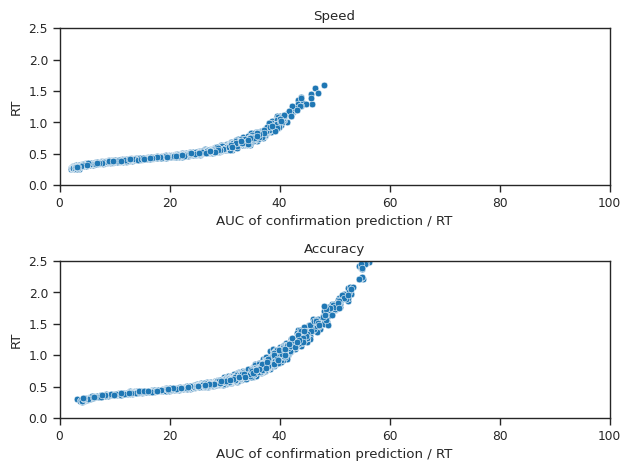

In [74]:
# Confirmation
plt.rcParams["figure.autolayout"] = True
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("tab10")
fig, ax = plt.subplots(2, 1)
ax[0].title.set_text("Speed")
sns.scatterplot(x=aucs_sp[:,3] / rts_sp, y=rts_sp, ax=ax[0])
ax[1].title.set_text("Accuracy")
sns.scatterplot(x=aucs_acc[:,3] / rts_acc, y=rts_acc, ax=ax[1])
plt.setp(ax, xlim=(0, 100), ylim=(0, 2.5), ylabel="RT (in seconds)", xlabel="AUC of confirmation prediction / RT")
plt.plot();

# Relative Confirmation increase does show an increase in RT, if error rates match

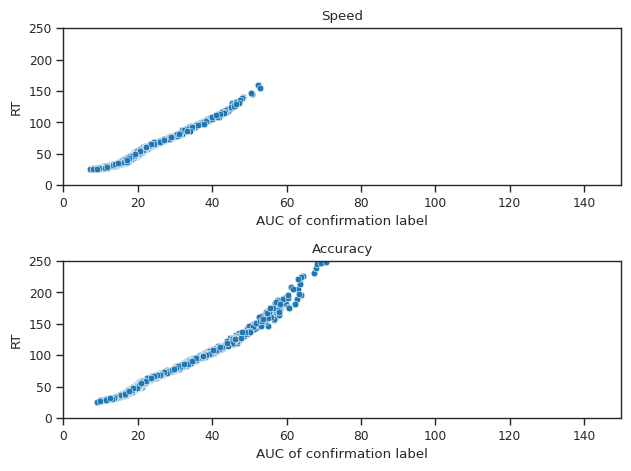

In [33]:
plt.rcParams["figure.autolayout"] = True
sns.set_style("ticks")
sns.set_context("paper")
sns.set_palette("tab10")
fig, ax = plt.subplots(2, 1)
ax[0].title.set_text("Speed")
sns.scatterplot(x=aucs_sp[:,2], y=rts_sp, ax=ax[0])
ax[1].title.set_text("Accuracy")
sns.scatterplot(x=aucs_acc[:,2], y=rts_acc, ax=ax[1])
plt.setp(ax, xlim=(0, 150), ylim=(0, 250), ylabel="RT", xlabel="AUC of confirmation label")
plt.plot();